# Functions and configurations

In [20]:
# Built-in modules
import sys
import os
from glob import glob
from datetime import datetime
from time import perf_counter
from re import search, sub, findall

# Data processing libraries
import numpy as np
import pandas as pd
import xlrd
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

# Machine learning libraries
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# Custom functions
sys.path.append('H:/Documents/Python Scripts')
sys.path.append('\\trinity-health.org\corp\HQ\TH\home\H\dmnb4898\Documents\Python Scripts')
from dataframe_udfs import *
from atomic_1darr_udfs import *

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 2000
pd.options.display.max_seq_items = 2000

%matplotlib inline

# Read and process data

In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", 
                 header=None, 
                 error_bad_lines=False)

X = df.iloc[:, :13]\
    .replace('?', 0)\
    .apply(lambda x: x.astype(float), 
           axis=0)
y = pd.Series(
    np.where(df.iloc[:, 13]>0,
             1, 0))

# print(y.value_counts())
# print(X.dtypes)

## PCA

In [23]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Clustering
## Baseline cluster with K means, 2 clusters

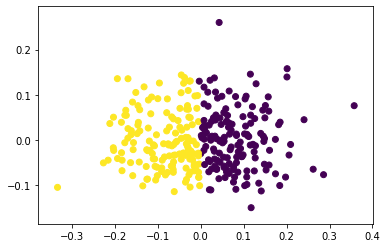

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      99  55
1      65  84


In [27]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

## Clustering with MiniBatch

In [29]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))
print('\nMini batch k-means accuracy')
print(pd.crosstab(predict_mini, y))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        0  138
1      154   11

Mini batch k-means accuracy
col_0    0   1
row_0         
0       57  81
1      107  58


## Changing the number of clusters for k-means

In [79]:
start = perf_counter()
preds = pd.concat(list(map(lambda x: pd.Series(KMeans(n_clusters=x)\
                                     .fit_predict(X_pca),
                                     name='clusters_{}'.format(x)),
                 np.arange(start=2, stop=21))),
                  axis=1)
stop = perf_counter()
preds = pd.concat([preds, pd.Series(y, name='target')], axis=1)
print('K-means complete, {0:.3f} seconds elapsed'\
     .format(stop-start))

K-means complete, 1.001 seconds elapsed


In [81]:
def cluster_results(x, threshold = 0.5):
    results = pd.concat([preds[[x, 'target']].groupby(x).mean(),
                         preds[[x, 'target']].groupby(x).size(),
                         preds[[x, 'target']].groupby(x).sum()],
                        axis=1)
    results.columns = ['cluster_mean', 'size', 'heart_disease']
    results['no_heart_disease'] = results['size'] - results['heart_disease']
    results['prediction'] = np.where(results['cluster_mean']<threshold, 0, 1)
    results['error'] = np.where(results['prediction']==1,
                                results['no_heart_disease'],
                                results['heart_disease'])
    return(results)

kmn_results = list(map(cluster_results, 
        list(filter(lambda x: x!='target', preds.columns))))


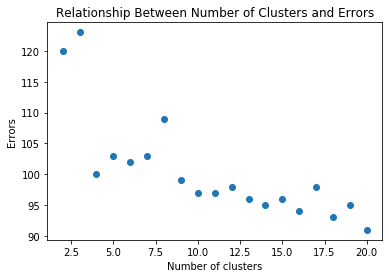

In [82]:
err = list(map(lambda x: x.error.sum(), kmn_results))

plt.scatter(np.arange(start=2, stop=21), err)
plt.title('Relationship Between Number of Clusters and Errors')
plt.xlabel('Number of clusters')
plt.ylabel('Errors')
plt.show()

In [83]:
print(err)

[120, 123, 100, 103, 102, 103, 109, 99, 97, 97, 98, 96, 95, 96, 94, 98, 93, 95, 91]


## Changing the number of clusters using MiniBatch

In [89]:
start = perf_counter()
mini_preds = pd.concat(
    list(map(lambda x: pd.Series(MiniBatchKMeans(
        init='random',
        n_clusters=x,
        batch_size=200)\
                                 .fit_predict(X_pca),
                                 name='clusters_{}'.format(x)),
             np.arange(start=2, stop=21))),
    axis=1)
stop = perf_counter()

print('Mini batch k-means complete, {0:.3f} seconds elapsed'\
     .format(stop-start))

Mini batch k-means complete, 0.368 seconds elapsed


In [90]:
mini_preds['target'] = y

mini_results = list(map(cluster_results, 
        list(filter(lambda x: x!='target', mini_preds.columns))))

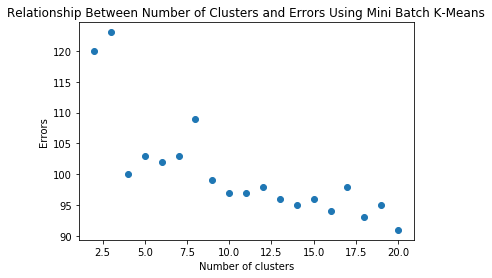

[120, 123, 100, 103, 102, 103, 109, 99, 97, 97, 98, 96, 95, 96, 94, 98, 93, 95, 91]


In [96]:
mini_err = list(map(lambda x: x.error.sum(), mini_results))

plt.scatter(np.arange(start=2, stop=21), mini_err)
plt.title('Relationship Between Number of Clusters and Errors Using Mini Batch K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('Errors')
plt.show()
print(mini_err)

# Conclusions
We tested the effect of cluster number on the prediction accuracy by testing 2 - 20 clusters. As we see in the graph above, errors generally decrease as the number of clusters increase. The sharpest decrease was between three and four. If we used the "elbow" method we would therefore likely choose 4 as the number of clusters. That being said, these are not great results.

K-means and mini batch k-means performed equivalently. They showed the same relationship between cluster number and accuracy, including having an "elbow" at 4 clusters. Mini batch did perform faster, taking a little under 0.4 seconds compared to a bit over 1 second for traditional k-means. However, this dataset was very small. This computational improvement would be more important for larger datasets.